In [5]:
pip install xgboost shap

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import shap

In [7]:
df = pd.read_csv("heart.csv")  # Make sure this CSV is in your current directory

In [8]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1
1024,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


In [9]:
df = pd.read_csv("heart.csv")  # Make sure this CSV is in your current directory
X = df.drop('target', axis=1)
y = df['target']

In [10]:
# 3. Feature Scaling + Selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = np.array(X.columns)[selector.get_support()]

In [12]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [13]:
# 5. Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]
rf_preds = rf.predict(X_test)

In [14]:
# 6. Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_probs = xgb.predict_proba(X_test)[:, 1]
xgb_preds = xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [15]:
# 7. Combine Predictions
simple_avg_probs = (rf_probs + xgb_probs) / 2
weighted_avg_probs = 0.4 * rf_probs + 0.6 * xgb_probs

simple_avg_preds = (simple_avg_probs >= 0.5).astype(int)
weighted_avg_preds = (weighted_avg_probs >= 0.5).astype(int)

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(name, y_true, y_pred, y_probs):
    print(f"--- {name} ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("ROC AUC  :", roc_auc_score(y_true, y_probs))

    # Confusion Matrix
    plt.style.use('ggplot')
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues_r', values_format='.0f')  # Reversed Blues for better contrast
    plt.title(f"{name} - Confusion Matrix", fontsize=14, fontweight='bold', pad=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # ROC Curve
    plt.style.use('ggplot')
    plt.figure(figsize=(6, 5))
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_true, y_probs):.2f})', color='#1f77b4', linewidth=2)
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)
    plt.xlabel('False Positive Rate', fontsize=20, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=20, fontweight='bold')
    plt.title(f'{name} - ROC Curve', fontsize=20, fontweight='bold', pad=10)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

--- Random Forest ---
Accuracy : 0.8536585365853658
Precision: 0.8173913043478261
Recall   : 0.912621359223301
ROC AUC  : 0.9437464306110794


<Figure size 600x500 with 0 Axes>

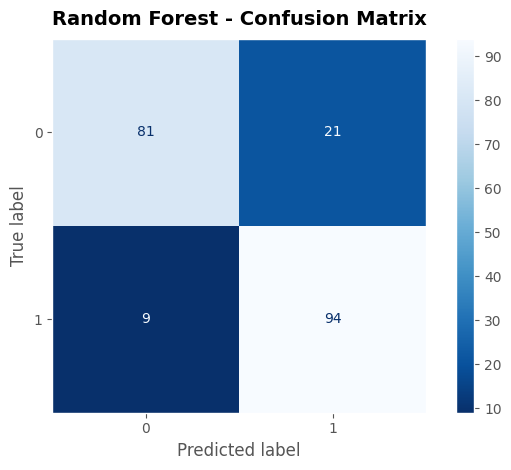

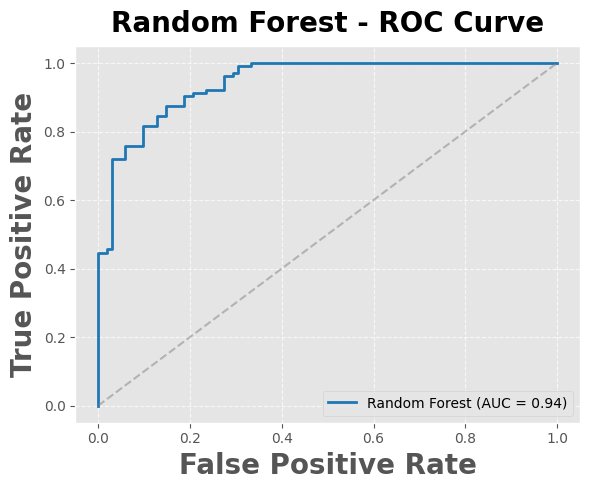

--- XGBoost ---
Accuracy : 0.9853658536585366
Precision: 1.0
Recall   : 0.970873786407767
ROC AUC  : 0.9882924043403769


<Figure size 600x500 with 0 Axes>

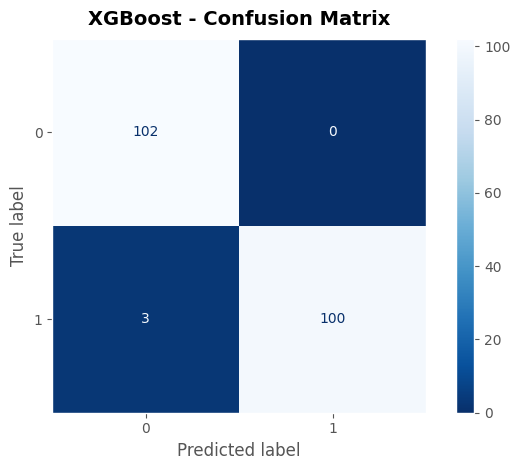

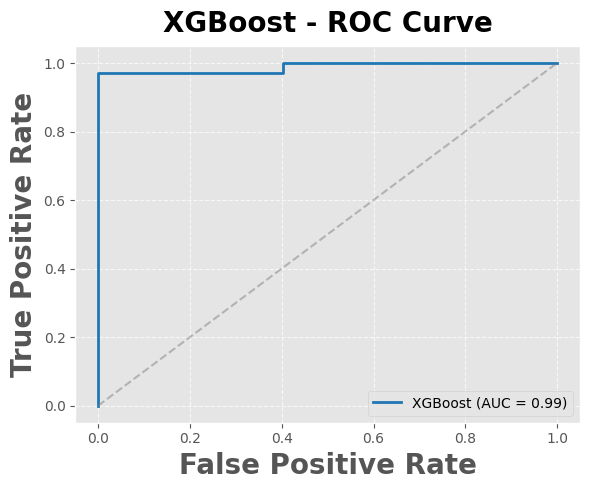

--- Simple Average ---
Accuracy : 0.9853658536585366
Precision: 1.0
Recall   : 0.970873786407767
ROC AUC  : 0.9914334665905197


<Figure size 600x500 with 0 Axes>

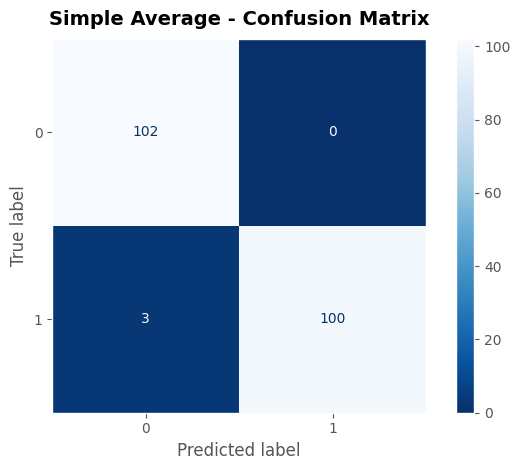

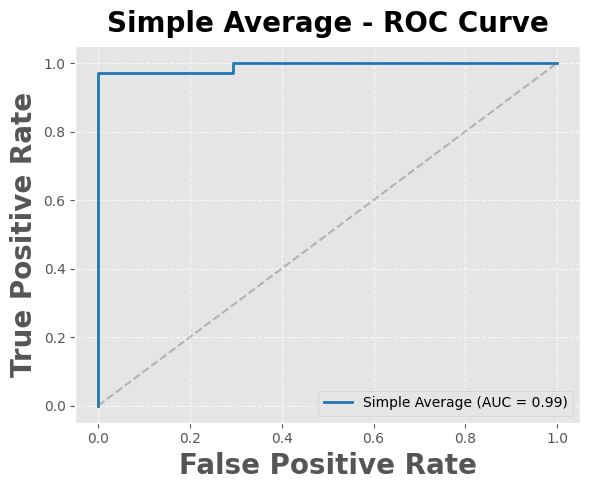

--- Weighted Average ---
Accuracy : 0.9853658536585366
Precision: 1.0
Recall   : 0.970873786407767
ROC AUC  : 0.9914334665905197


<Figure size 600x500 with 0 Axes>

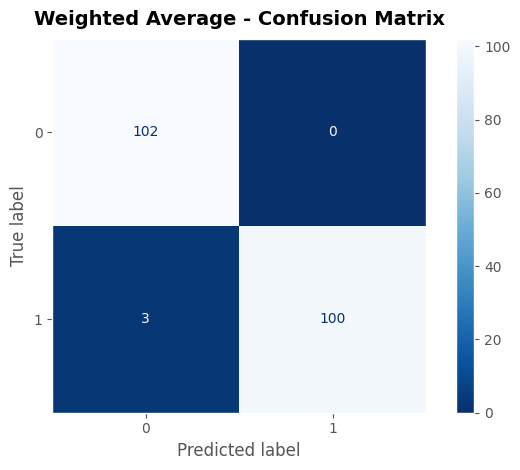

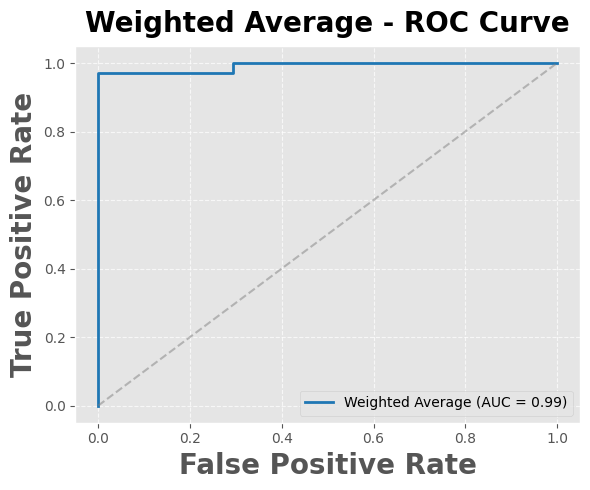

In [74]:
# 9. Evaluate All Models
evaluate_model("Random Forest", y_test, rf_preds, rf_probs)
evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)
evaluate_model("Simple Average", y_test, simple_avg_preds, simple_avg_probs)
evaluate_model("Weighted Average", y_test, weighted_avg_preds, weighted_avg_probs)

In [51]:
from mpl_toolkits.mplot3d import Axes3D

3D SHAP Visualization (Alternative)

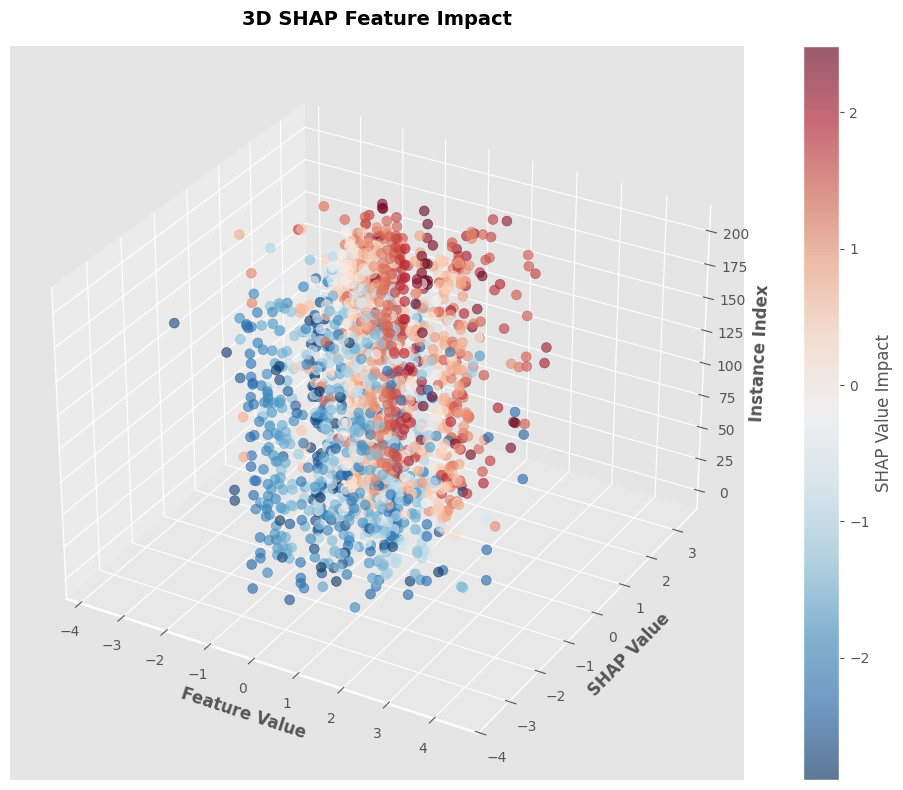

In [58]:
# Compute SHAP values
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Set style
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract data for 3D plot
for i, feature in enumerate(selected_features):
    x = X_test[:, i]  # Feature values
    y = shap_values[:, i].values  # SHAP values
    z = np.arange(len(x))  # Instance index as Z-axis
    scatter = ax.scatter(x, y, z, c=y, cmap='RdBu_r', alpha=0.6, s=50)

# Customize labels and title
ax.set_xlabel('Feature Value', fontsize=12, fontweight='bold')
ax.set_ylabel('SHAP Value', fontsize=12, fontweight='bold')
ax.set_zlabel('Instance Index', fontsize=12, fontweight='bold')
ax.set_title('3D SHAP Feature Impact', fontsize=14, fontweight='bold', pad=15)

# Add color bar
plt.colorbar(scatter, ax=ax, label='SHAP Value Impact')

# Adjust layout
plt.tight_layout()
plt.show()

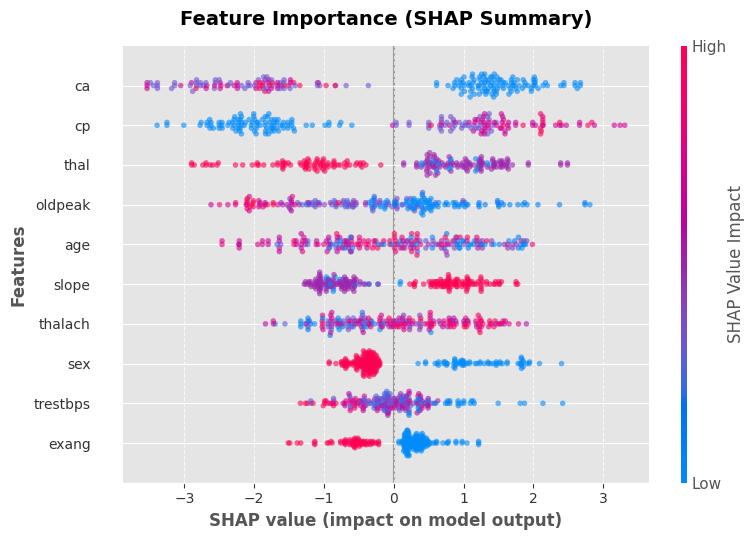

In [62]:
import shap
import matplotlib.pyplot as plt

# Compute SHAP values
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Set style for a polished look
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

# Create beautified summary plot
shap.summary_plot(shap_values, X_test, feature_names=selected_features,
                  show=False,  # Disable automatic display
                  color_bar_label='SHAP Value Impact',
                  plot_type="dot",  # Use dot plot for clarity
                  color='#ff6b6b',  # Consistent red shade
                  alpha=0.6)  # Add transparency

# Customize labels and title
plt.xlabel('SHAP value (impact on model output)', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Feature Importance (SHAP Summary)', fontsize=14, fontweight='bold', pad=15)

# Adjust tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

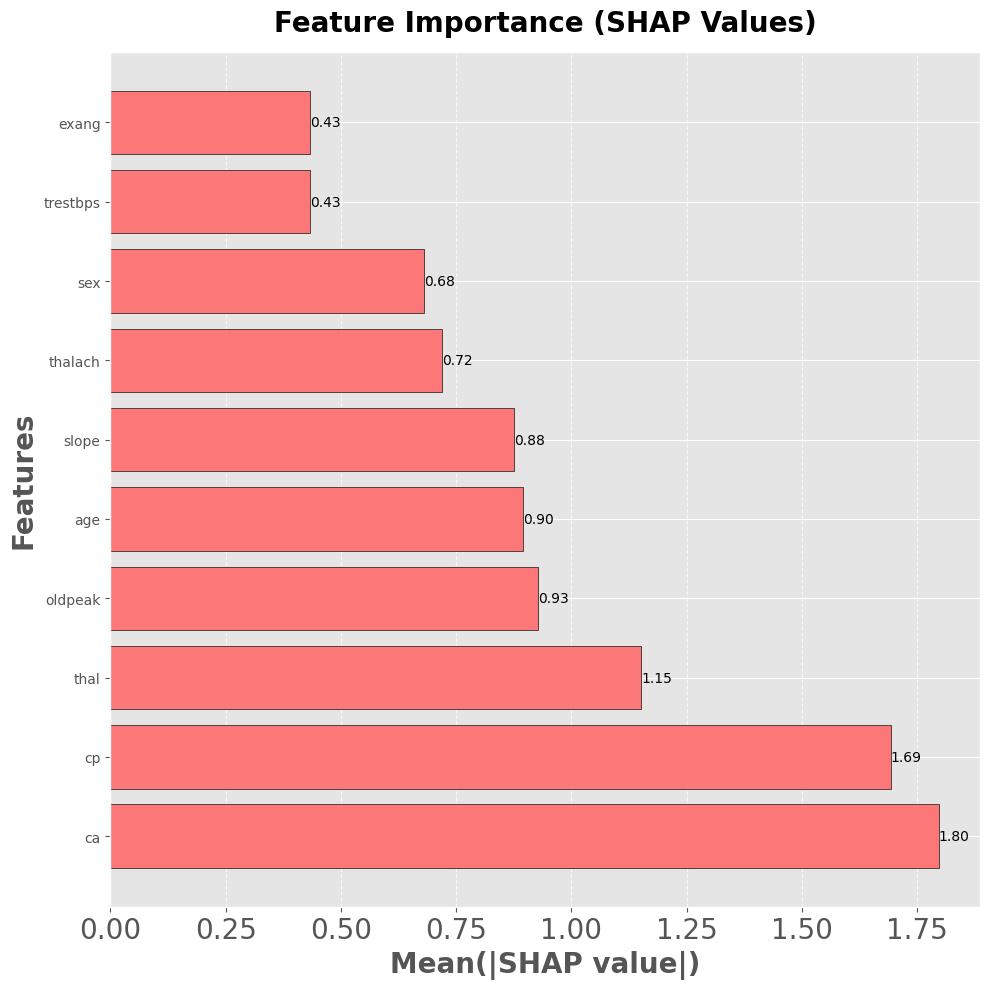

In [82]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Extract mean absolute SHAP values and feature names
shap_mean = np.abs(shap_values.values).mean(axis=0)
feature_names = selected_features  # Replace with your feature names if not defined

# Sort by mean SHAP value in descending order
sort_idx = np.argsort(shap_mean)[::-1]
shap_mean = shap_mean[sort_idx]
feature_names = [feature_names[i] for i in sort_idx]

# Set style and figure
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))

# Create bar plot with enhanced aesthetics
bars = plt.barh(range(len(shap_mean)), shap_mean, color='#ff6b6b', edgecolor='black', linewidth=0.5, alpha=0.9)
plt.xlabel('Mean(|SHAP value|)', fontsize=20, fontweight='bold')
plt.ylabel('Features', fontsize=20, fontweight='bold')
plt.title('Feature Importance (SHAP Values)', fontsize=20, fontweight='bold', pad=15)

# Customize ticks and labels
plt.yticks(range(len(feature_names)), feature_names, fontsize=10)
plt.xticks(fontsize=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{shap_mean[i]:.2f}',
             ha='left', va='center', fontsize=10, color='black')

# Adjust layout to prevent cutoff
plt.tight_layout()

# Show plot
plt.show()

In [19]:
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy :", rf.score(X_test, y_test))


Train Accuracy: 0.9426829268292682
Test Accuracy : 0.8536585365853658


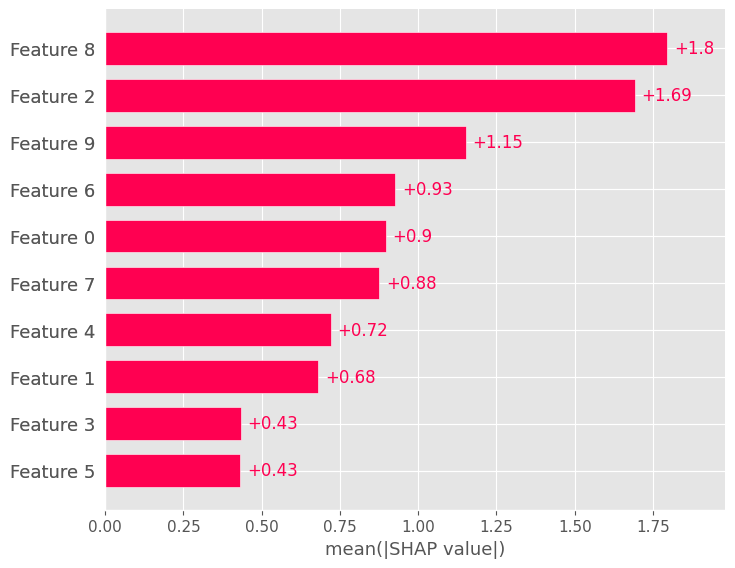

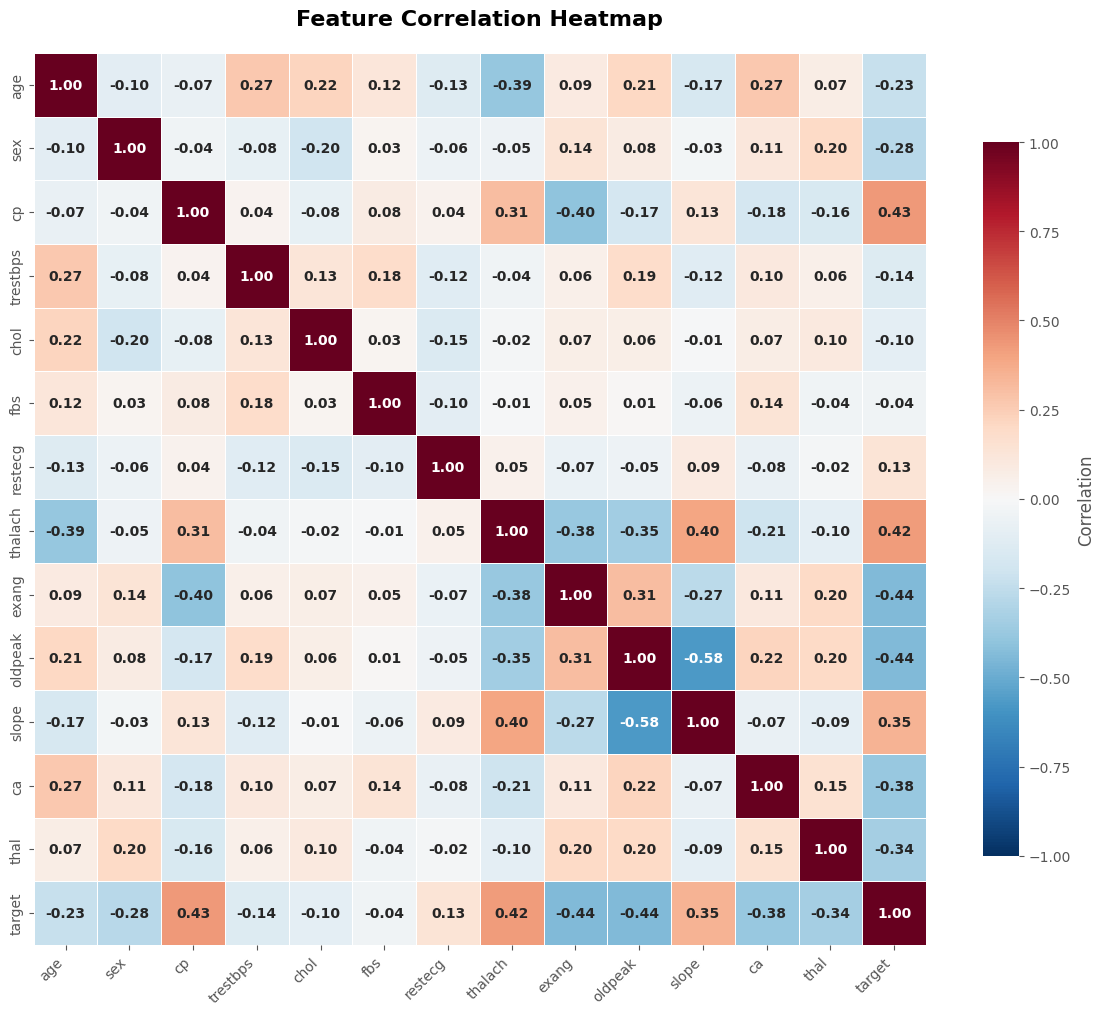

In [39]:


# Correlation heatmap
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))

# Create heatmap with enhanced parameters
sns.heatmap(df.corr(),
            annot=True,
            cmap='RdBu_r',  # Reversed Red-Blue colormap for better contrast
            annot_kws={"size": 10, "weight": "bold"},  # Bold and sized annotations
            fmt='.2f',  # Two decimal places for clarity
            square=True,  # Square cells for uniformity
            linewidths=0.5,  # Thin lines between cells
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'},  # Customized color bar
            vmin=-1, vmax=1)  # Set bounds for better color scaling

# Customize title and labels
plt.title("Feature Correlation Heatmap", fontsize=16, fontweight='bold', pad=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add a subtle grid (optional for creativity)
plt.grid(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

In [21]:
# Assuming you've already trained rf and xgb
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]

# Weighted average of predicted probabilities
w1, w2 = 0.6, 0.4  # You can adjust the weights
ensemble_probs = w1 * rf_probs + w2 * xgb_probs


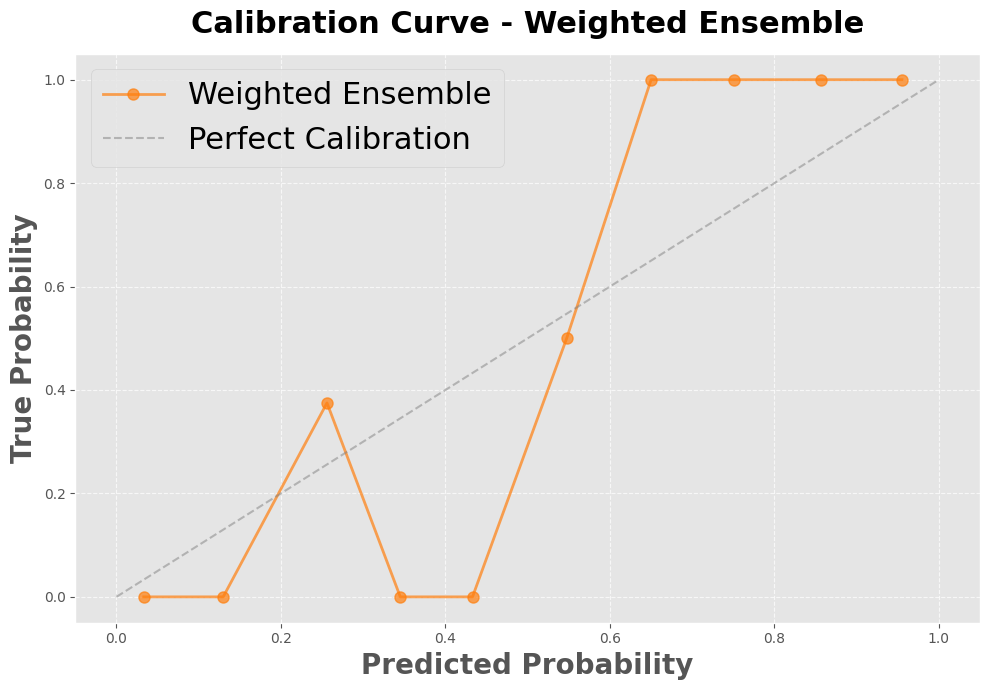

In [36]:
from sklearn.calibration import calibration_curve

plt.style.use('ggplot')
plt.figure(figsize=(10, 7))

# Compute calibration curve
prob_true_ensemble, prob_pred_ensemble = calibration_curve(y_test, ensemble_probs, n_bins=10)

# Plot with enhanced aesthetics
plt.plot(prob_pred_ensemble, prob_true_ensemble, marker='o', linestyle='-', linewidth=2, markersize=8, label='Weighted Ensemble', color='#ff7f0e', alpha=0.7)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.5, label='Perfect Calibration', alpha=0.5)

# Customize labels and title
plt.xlabel("Predicted Probability", fontsize=20, fontweight='bold')
plt.ylabel("True Probability", fontsize=20, fontweight='bold')
plt.title("Calibration Curve - Weighted Ensemble", fontsize=22, fontweight='bold', pad=15)

# Add legend and grid
plt.legend(fontsize=22)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [28]:
pip install seaborn

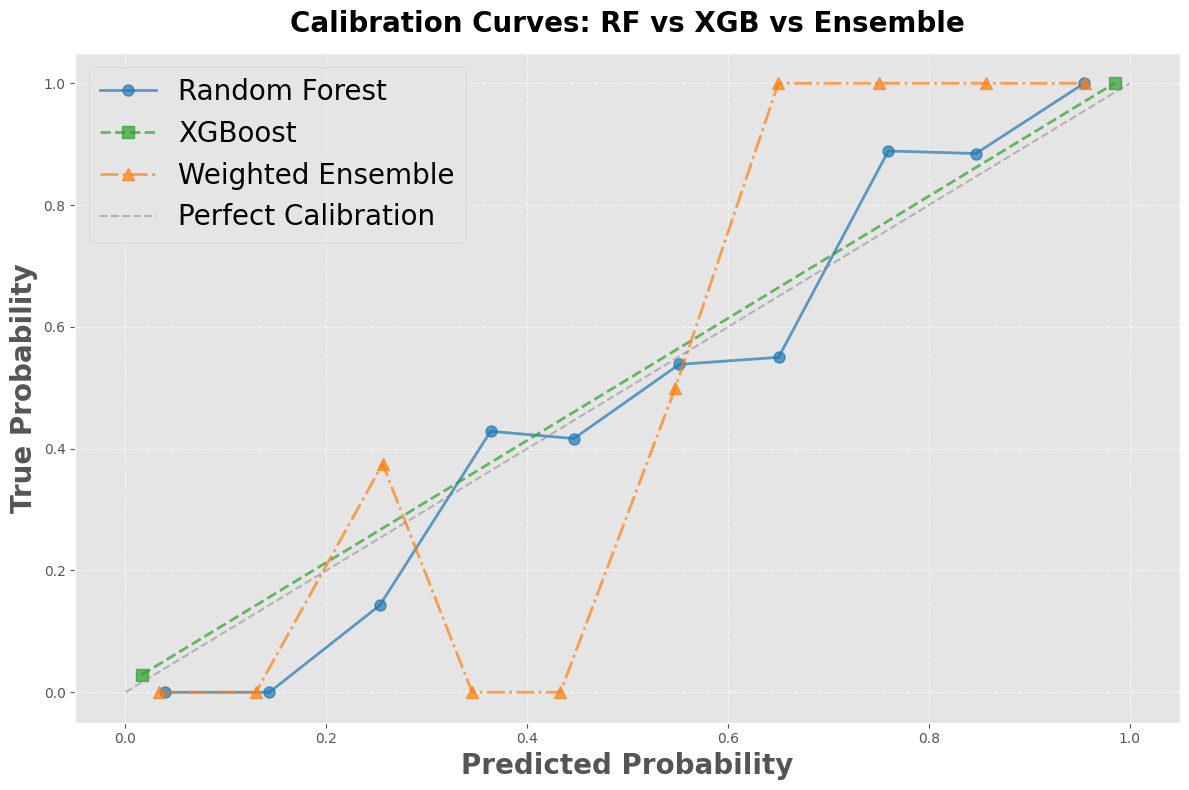

In [33]:
import matplotlib.pyplot as plt

# Set style
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

# Predicted probabilities
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]
ensemble_probs = 0.6 * rf_probs + 0.4 * xgb_probs  # Weighted average

# Compute calibration curves
rf_true, rf_pred = calibration_curve(y_test, rf_probs, n_bins=10)
xgb_true, xgb_pred = calibration_curve(y_test, xgb_probs, n_bins=10)
ensemble_true, ensemble_pred = calibration_curve(y_test, ensemble_probs, n_bins=10)

# Plot with enhanced aesthetics
plt.plot(rf_pred, rf_true, marker='o', linestyle='-', linewidth=2, markersize=8, label='Random Forest', color='#1f77b4', alpha=0.7)
plt.plot(xgb_pred, xgb_true, marker='s', linestyle='--', linewidth=2, markersize=8, label='XGBoost', color='#2ca02c', alpha=0.7)
plt.plot(ensemble_pred, ensemble_true, marker='^', linestyle='-.', linewidth=2, markersize=8, label='Weighted Ensemble', color='#ff7f0e', alpha=0.7)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.5, label='Perfect Calibration', alpha=0.5)

# Customize labels and title
plt.xlabel("Predicted Probability", fontsize=20, fontweight='bold')
plt.ylabel("True Probability", fontsize=20, fontweight='bold')
plt.title("Calibration Curves: RF vs XGB vs Ensemble", fontsize=20, fontweight='bold', pad=15)

# Add legend and grid
plt.legend(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

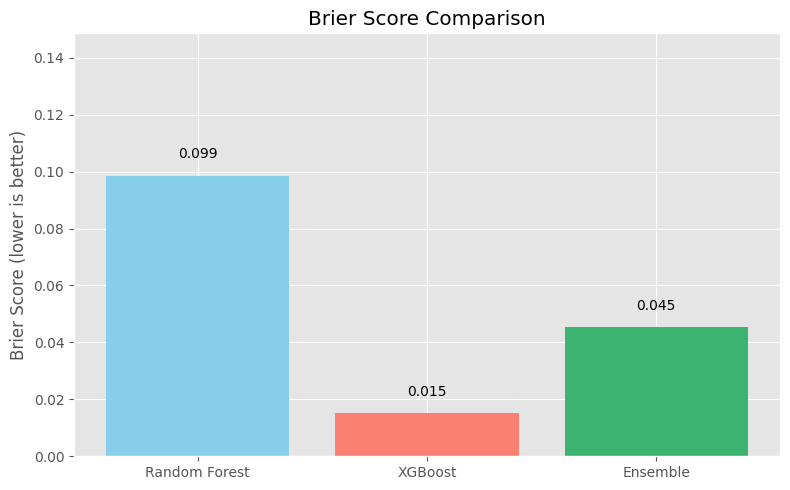

In [93]:
import matplotlib.pyplot as plt

# Example Brier scores (replace with your actual values)
brier_rf = brier_score_loss(y_test, rf_probs)
brier_xgb = brier_score_loss(y_test, xgb_probs)
brier_ensemble = brier_score_loss(y_test, ensemble_probs)

# Labels and values
models = ['Random Forest', 'XGBoost', 'Ensemble']
scores = [brier_rf, brier_xgb, brier_ensemble]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores, color=['skyblue', 'salmon', 'mediumseagreen'])
plt.title('Brier Score Comparison')
plt.ylabel('Brier Score (lower is better)')
plt.ylim(0, max(scores) + 0.05)

# Adding score labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



Lower = better calibrated.